In [1]:
from matplotlib import pyplot as plt
from astropy.visualization import ImageNormalize, MinMaxInterval, LogStretch
from astropy.convolution import convolve, Gaussian2DKernel
import numpy as np
from numpy import sqrt, arctan
from xga.products.phot import RateMap, Image, ExpMap
from xga.sourcetools import ang_to_rad
from xga.sources import GalaxyCluster
from xga.imagetools import radial_brightness, ann_radii, pix_deg_scale
from xga.imagetools.deproj import sph_cir_vol_int
from xga.imagetools import data_limits

from astropy.units import Quantity, pix, kpc
from matplotlib.ticker import ScalarFormatter
import imageio
from mayavi import mlab
# mlab.init_notebook(backend='ipy')

In [2]:
cust_rad = Quantity(800, 'kpc')
# This is actually a real measurement of the A907 r500
r500 = Quantity(1200, 'kpc')
a907 = GalaxyCluster(149.5904478, -11.062875, redshift=0.16, name="A907", r500=r500, load_products=True,
                      load_fits=True, custom_region_radius=cust_rad, clean_obs=False)

/Users/dt237/code/PycharmProjects/XGA/xga/products/phot.py:69: UserWarning: You are loading an ratemap with elements that are < 0, they will be set to 0.
  "they will be set to 0.".format(self._prod_type))


In [3]:
a907.info()


-----------------------------------------------------
Source Name - A907
User Coordinates - (149.5904478, -11.062875) degrees
X-ray Centroid - (149.59251340970866, -11.063958320861637) degrees
nH - 0.053 1e+22 / cm2
Redshift - 0.16
XMM ObsIDs - 3
PN Observations - 3
MOS1 Observations - 3
MOS2 Observations - 3
On-Axis - 3
With regions - 3
Total regions - 69
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 45
Exposure maps associated - 18
Combined Ratemaps associated - 4
Spectra associated - 0
Custom Region Radius - 800.0 kpc
Custom Region SNR - 4.57
R500 - 1200.0 kpc
R500 SNR - 2.71
-----------------------------------------------------



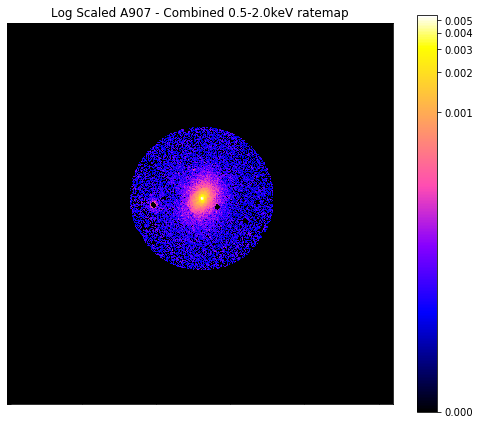

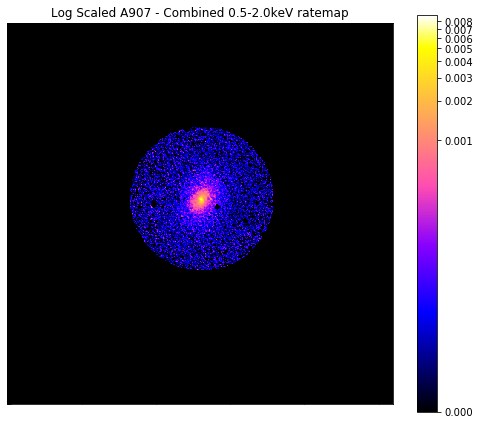

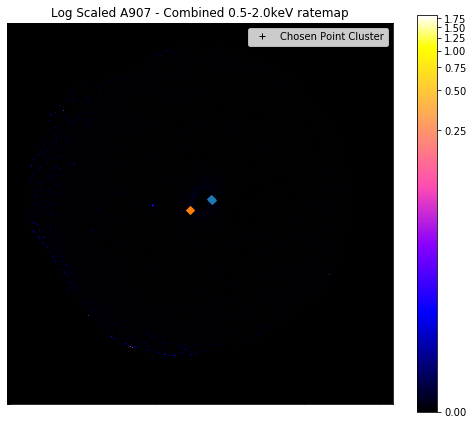

In [4]:
a907_rt = [rt[-1] for rt in a907.get_products("combined_ratemap", just_obj=False) 
           if "bound_0.5-2.0" in rt][0]
a907_psf_rt = [rt[-1] for rt in a907.get_products("combined_ratemap", just_obj=False) 
               if "bound_0.5-2.0_ELLBETA_4_rl15" in rt][0]
source_mask, background_mask = a907.get_mask("r500")
a907_rt.view(mask=source_mask)
a907_psf_rt.view(mask=source_mask)

a907_psfed_peak_pack = a907.find_peak(a907_psf_rt)
a907_psf_rt.view(chosen_points=a907_psfed_peak_pack[3], other_points=a907_psfed_peak_pack[4])

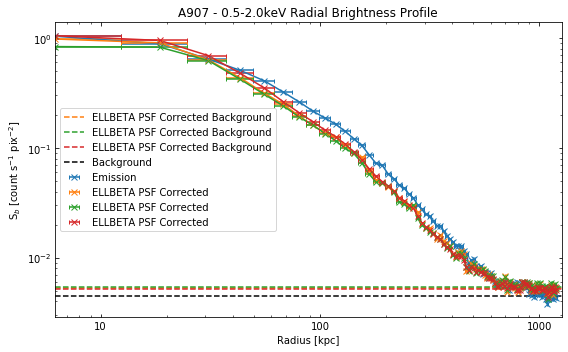

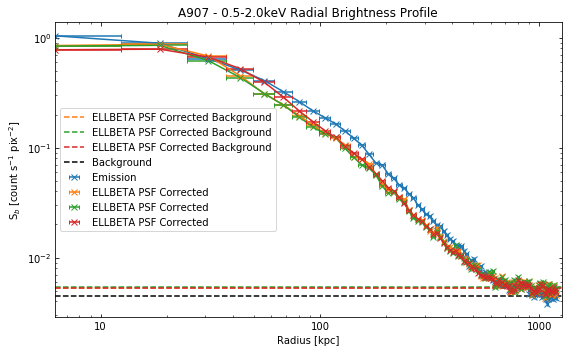

In [5]:
a907.view_brightness_profile("r500", "radial")
a907.view_brightness_profile("r500", "radial", same_peak=False)

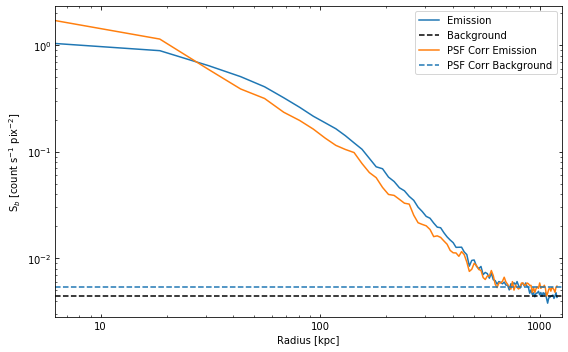

In [6]:
# Get combined peak - basically the only peak internal methods will use
pix_peak = a907_rt.coord_conv(a907.peak, pix)
rad = Quantity(a907.get_source_region('r500')[0].to_pixel(a907_rt.radec_wcs).radius, pix)


# Setup the figure
plt.figure(figsize=(8, 5))
ax = plt.gca()

og_brightness, radii, rad_err, og_background = radial_brightness(a907_rt, source_mask, background_mask, pix_peak,
                                                     rad, a907.redshift, 1, kpc, a907.cosmo)
plt.plot(radii, og_brightness, label="Emission")

# Plot the background level
plt.axhline(og_background, color="black", linestyle="dashed", label="Background")

psf_peak = a907_psf_rt.clustering_peak(source_mask, pix)[0]
psf_brightness, radii, rad_err, psf_background = radial_brightness(a907_psf_rt, source_mask, background_mask, psf_peak,
                                                     rad, a907.redshift, 1, kpc, a907.cosmo)
plt.plot(radii, psf_brightness, label="PSF Corr Emission")

# Plot the background level
plt.axhline(psf_background, linestyle="dashed", label="PSF Corr Background")

# This adds small ticks to the axis
ax.minorticks_on()
# Set the lower limit of the x-axis to 0
ax.set_xlim(0,)
# Adjusts how the ticks look
ax.tick_params(axis='both', direction='in', which='both', top=True, right=True)
# Choose y-axis log scaling because otherwise you can't really make out the profiles very well
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(radii.min().value, )
ax.xaxis.set_major_formatter(ScalarFormatter())

# Labels and legends
ax.set_ylabel("S$_{b}$ [count s$^{-1}$ pix$^{-2}$]")
ax.set_xlabel("Radius [kpc]")
plt.legend(loc="best")
# Removes white space around the plot
plt.tight_layout()
# Plots the plot
plt.show()
plt.close('all')

In [7]:
inn, out, cen = ann_radii(a907_rt, pix_peak, rad, a907.redshift, 1, kpc, a907.cosmo)
rads = np.append(inn, out[-1])
a907_mixer = sph_cir_vol_int(rads, rads)

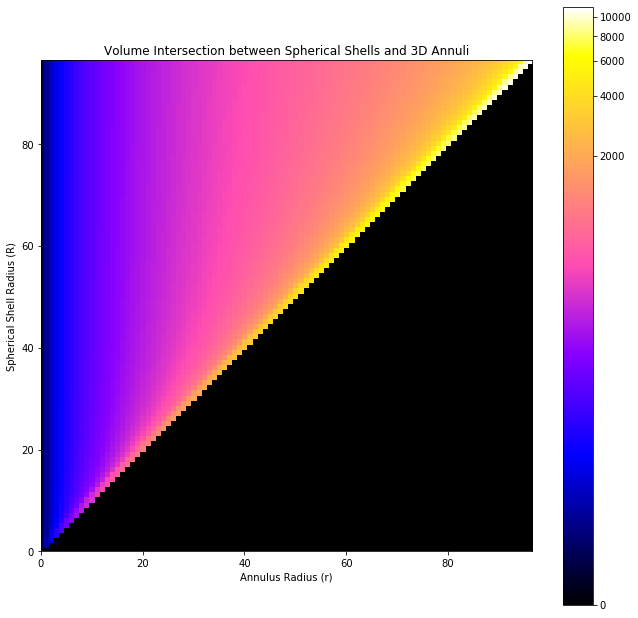

In [8]:
fig = plt.figure(figsize=(11, 11))
norm = ImageNormalize(a907_mixer, interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(a907_mixer, cmap="gnuplot2", norm=norm, origin="lower")
plt.colorbar()

sphere_cens = (rads[1:] + rads[:-1])/2
ann_cens = (rads[1:] + rads[:-1])/2

plt.xlim(0)
plt.ylim(0)

# plt.xticks(np.arange(0, a907_mixer.shape[1], 10), ann_cens[np.arange(0, a907_mixer.shape[1], 10)].round(2))
# plt.yticks(np.arange(0, a907_mixer.shape[0], 10), sphere_cens[np.arange(0, a907_mixer.shape[0], 10)].round(2))

plt.title("Volume Intersection between Spherical Shells and 3D Annuli")
plt.ylabel("Spherical Shell Radius (R)")
plt.xlabel("Annulus Radius (r)")

plt.show()

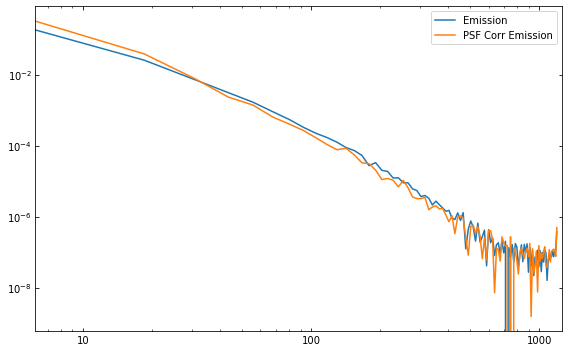

In [9]:
# Setup the figure
plt.figure(figsize=(8, 5))
ax = plt.gca()

plt.plot(radii, og_brightness@np.linalg.inv(a907_mixer), label="Emission")
plt.plot(radii, psf_brightness@np.linalg.inv(a907_mixer), label="PSF Corr Emission")

# This adds small ticks to the axis
ax.minorticks_on()
# Set the lower limit of the x-axis to 0
ax.set_xlim(0,)
# Adjusts how the ticks look
ax.tick_params(axis='both', direction='in', which='both', top=True, right=True)
# Choose y-axis log scaling because otherwise you can't really make out the profiles very well
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(radii.min().value, )
ax.xaxis.set_major_formatter(ScalarFormatter())

# Labels and legends
# ax.set_ylabel("S$_{b}$ [count s$^{-1}$ pix$^{-2}$]")
# ax.set_xlabel("Radius [kpc]")
plt.legend(loc="best")

# plt.ylim(10e-10, 10e-3)

# Removes white space around the plot
plt.tight_layout()
# Plots the plot
plt.show()
plt.close('all')

## Testing z change

/Users/dt237/software/anaconda3/envs/XGA/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


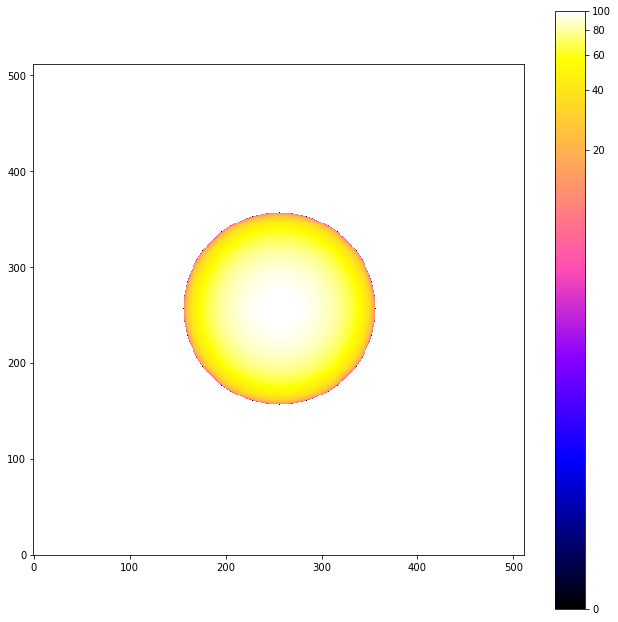

In [10]:
def z_ch(r, x, x_c, y, y_c, z_c):
    return ((r**2 - (x-x_c)**2 - (y-y_c)**2))**0.5 + z_c

arb_space = np.meshgrid(np.arange(0, 512, 1), np.arange(0, 512, 1))

z_image = z_ch(100, arb_space[0], 256, arb_space[1], 256, 0)

fig = plt.figure(figsize=(11, 11))
norm = ImageNormalize(z_image, interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(z_image, cmap="gnuplot2", norm=norm, origin="lower")
plt.colorbar()

plt.show()

## Pixel based volume weighting method - Silly Idea?

Lets hope this isn't bullshit!

### Defining my horrifiying integral

In [11]:
def pix_vol_int(x_1, x_2, y_1, y_2, r):
    pain_1 = y_2*x_2*sqrt(r**2-y_2**2-x_2**2) + x_2*(3*r**2 + x**2)*arctan(y_2/sqrt(r**2-y_2**2-x_2**2))
    pain_2 = (6*r**2*y_2 - 2*y_2**3)*arctan(x_2/sqrt(r**2-y_2**2-x_2**2)) - y_1*x_2*sqrt(r**2-y_1**2-x_2**2)
    pain_3 = -3*r**2*x_2*arctan(y_1/sqrt(r**2-y_1**2-x_2**2)) - 6*r**2*y_1*arctan(x_2/sqrt(r**2-y_1**2-x_2**2))
    pain_4 = -x_2**3*arctan(y_1/sqrt(r**2-y_1**2-x_2**2)) + 2*y_1**3*arctan(x_2/sqrt(r**2-y_1**2-x_2**2))
    pain_5 = -4*r**3*arctan((y_2*x_2)/(r*sqrt(r**2-y_2**2-x_2**2)))
    pain_6 = 4*r**3*arctan((y_1*x_2)/(r*sqrt(r**2-y_1**2-x_2**2)))
    x2_pain = sum([pain_1, pain_2, pain_3, pain_4, pain_5, pain_6])
    
    pain_1 = y_2*x_1*sqrt(r**2-y_2**2-x_1**2) + x_1*(3*r**2 + x**2)*arctan(y_2/sqrt(r**2-y_2**2-x_1**2))
    pain_2 = (6*r**2*y_2 - 2*y_2**3)*arctan(x_1/sqrt(r**2-y_2**2-x_1**2)) - y_1*x_1*sqrt(r**2-y_1**2-x_1**2)
    pain_3 = -3*r**2*x_1*arctan(y_1/sqrt(r**2-y_1**2-x_1**2)) - 6*r**2*y_1*arctan(x_1/sqrt(r**2-y_1**2-x_1**2))
    pain_4 = -x_1**3*arctan(y_1/sqrt(r**2-y_1**2-x_1**2)) + 2*y_1**3*arctan(x_1/sqrt(r**2-y_1**2-x_1**2))
    pain_5 = -4*r**3*arctan((y_2*x_1)/(r*sqrt(r**2-y_2**2-x_1**2)))
    pain_6 = 4*r**3*arctan((y_1*x_1)/(r*sqrt(r**2-y_1**2-x_1**2)))
    x1_pain = sum([pain_1, pain_2, pain_3, pain_4, pain_5, pain_6])
    
    vol = x2_pain - x1_pain
    return vol

def new_z(x, x_c, y, y_c, r):
    thing = r**2 - (x-x_c)**2 - (y-y_c)**2
    thing[thing < 0] = 0
    return sqrt(thing)

def simple_pix_vol_int(x_space, y_space, rad_space, x_c, y_c): 
    return 2*(new_z(x_space[:, :, 1:], x_c, y_space[:, :, 1:], y_c, rad_space[:, :, 1:]) * 1 * 1 \
           - new_z(x_space[:, :, :-1], x_c, y_space[:, :, :-1], y_c, rad_space[:, :, :-1]) * 1 * 1)

### What sort of results does it produce?

In [12]:
max_rad = rad.value
rad_bins = np.arange(0, max_rad, 2)
cen_rads = (rad_bins[1:] + rad_bins[:-1]) / 2

pix_space_r = np.meshgrid(np.arange(0, a907_rt.shape[1], 1), np.arange(0, a907_rt.shape[0], 1), rad_bins)

vols = simple_pix_vol_int(pix_space_r[0], pix_space_r[1], pix_space_r[2], psf_peak[0].value, psf_peak[1].value)

pix_space_max_r = np.meshgrid(np.arange(0, a907_rt.shape[1], 1), np.arange(0, a907_rt.shape[0], 1), 
                              np.linspace(0, max_rad, 2))
max_vols = simple_pix_vol_int(pix_space_max_r[0], pix_space_max_r[1], pix_space_max_r[2], psf_peak[0].value, 
                              psf_peak[1].value)
contributions = np.zeros(vols.shape)
np.divide(vols, max_vols, where=max_vols != 0, out=contributions)

print(pix_peak)
print(rad)

[262 276] pix
96.9001955137085 pix


## Lets play around with the contributions matrix

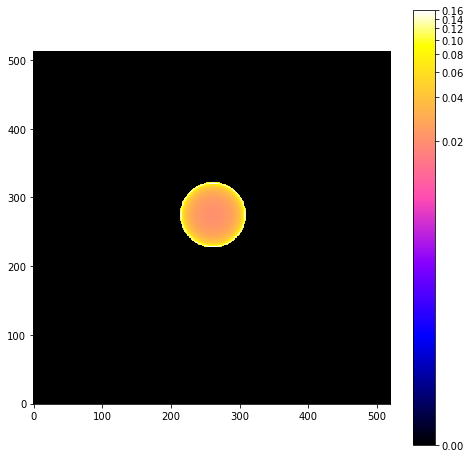

In [13]:
chosen = 23

plt.figure(figsize=(8, 8))
norm = ImageNormalize(contributions[:, :, chosen], interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(contributions[:, :, chosen], origin="lower", norm=norm, cmap="gnuplot2")
plt.colorbar()
plt.show()

In [14]:
norm_over_rate = 1.01143 / 0.224447

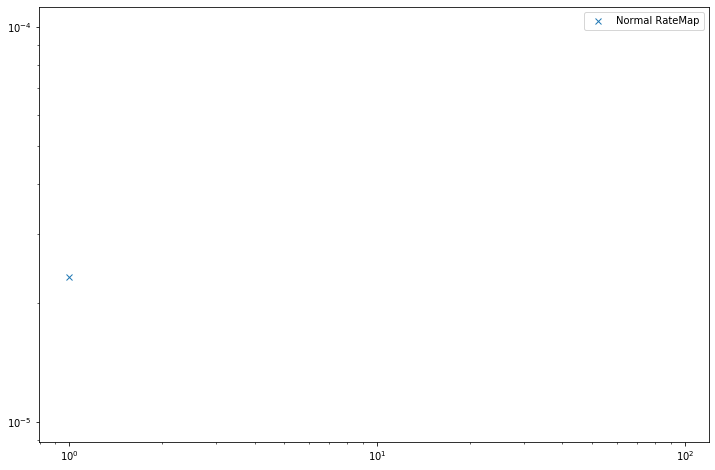

In [15]:
shell_vols = ((4*np.pi) / 3) * (rad_bins[1:]**3 - rad_bins[:-1]**3)

rt_contr = contributions*((a907_psf_rt.data[..., None]*source_mask[...,None] - psf_background)*norm_over_rate)
el_norm = ImageNormalize(rt_contr, interval=MinMaxInterval(), stretch=LogStretch())
rt_emissivity = np.divide(rt_contr.sum((0, 1)), shell_vols)

plt.figure(figsize=(12, 8))
plt.plot(cen_rads, rt_emissivity, 'x', label="Normal RateMap")
# plt.plot(cen_rads, psf_rt_emissivity, "D", label="PSF Corrected RateMap")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

### Also need to convert pixels to physical units

In [16]:
pix_to_deg = pix_deg_scale(a907.peak, a907_rt.radec_wcs)
pix_to_kpc = ang_to_rad(Quantity(pix_to_deg, "deg"), a907.redshift)
pix_to_cm = pix_to_kpc.to('cm')

pix_vol_to_cm_vol = (pix_to_cm**3).value
print(pix_vol_to_cm_vol)

5.579833192383757e+67


Super bodged conversion coming up

/Users/dt237/software/anaconda3/envs/XGA/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


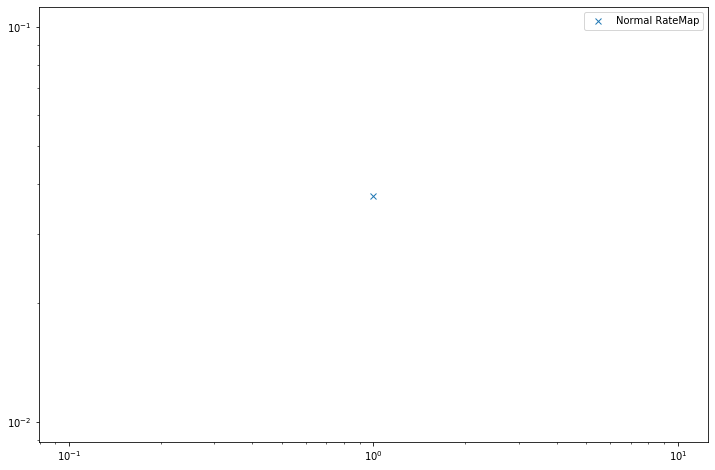

In [17]:
ne_nh = ((rt_emissivity/pix_vol_to_cm_vol) * (4*np.pi) * \
          a907.cosmo.angular_diameter_distance(a907.redshift).to('cm').value**2 * (1 + a907.redshift)**2) / 1e-14
# Probably bullshit
nh = sqrt(ne_nh / 1.21) * (a907.cosmo.inv_efunc(a907.redshift))**2

plt.figure(figsize=(12, 8))
plt.plot(cen_rads, nh, 'x', label="Normal RateMap")

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

Paul's conversion script

pag22/scripts/cnt2EI

# Things in 3D

I want to try a different approach to this, as Lucas suggested. Do discrete 3D masks for the intersections, and basically construct a cluster emissivity profile in 3D. This whole idea may be flawed, its a little difficult to visualise, so I'm hoping doing this and combining with Mayavi for 3D plots will help me explain it to others and get their opinions.

## Trying to set up a couple of spherical shells in a numpy array

In [18]:
def sphere_shell(x, y, z, x_c, y_c, z_c, r2, r1):
    r_sp = sqrt((x - x_c)**2 + (y - y_c)**2 + (z - z_c)**2)
    return (r_sp >= r1) & (r_sp < r2)

sphere_home = np.zeros((512, 512, 512))

line = np.arange(0, 512)
space = np.meshgrid(line, line, line)

sphere_home[sphere_shell(*space, 0, 256, 256, 200, 190)] = 1.0
sphere_home[sphere_shell(*space, 0, 256, 256, 150, 140)] = 0.5

fake_pix_space = np.meshgrid(np.arange(0, 512, 32), np.arange(0, 512, 32))
for ind, i in np.ndenumerate(fake_pix_space[0]):
    j = fake_pix_space[1][ind]
    sphere_home[i:i+6, :, j:j+6] = 2.0

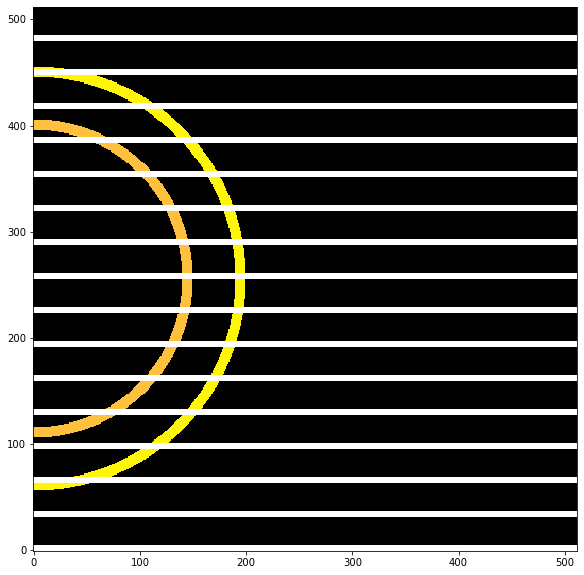

In [19]:
norm = ImageNormalize(sphere_home[:, :, 256], interval=MinMaxInterval(), stretch=LogStretch())
plt.figure(figsize=(10, 10))
plt.imshow(sphere_home[:, :, 256], norm=norm, cmap="gnuplot2", origin="lower")
plt.show()

In [20]:
mlab.pipeline.volume(mlab.pipeline.scalar_field(sphere_home), vmin=0)
#mlab.contour3d(sphere_home)
mlab.show()

## Actually using the shells

Right, so the thought I had was to essentially construct a representation of the cluster (using some assumptions) in a 3D numpy array. Again use the pixel volume weighting technique to spread the photons that arrive in a particular pixel out through a set of spherical or elliptical shells. This obviously assumes an angular symmetry in the direction of the line of sight (I don't know the right word for that), but it wouldn't assume symmetries in the radial direction, or the angular direction orthogonal to line of sight.

I don't know what benefits this will bring quite yet, but this way might make it easier to use different shapes to describe the idealised cluster profile - I feel like this is ripe for forward modelling, and we could gain some insight into the 3D shape of the cluster with forward modelling, but I don't know how to do it.

In [21]:
meh_space = np.meshgrid(np.arange(0, a907_rt.shape[1]), np.arange(0, a907_rt.shape[0]), np.arange(0, 512))
print(meh_space[0].shape, meh_space[1].shape, meh_space[2].shape)


ting = [p for p in a907.get_products("combined_ratemap", just_obj=False) 
        if 'bound_0.5-2.0_ELLBETA_4_rl15' in p][0][-1]
mask = a907.get_mask("r500")[0]

a907_og_x, a907_og_y = ting.coord_conv(a907.peak, pix).value
a907_psf_x, a907_psf_y = ting.clustering_peak(mask, pix)[0].value.astype(int)
print(a907_og_x, a907_og_y)
print(a907_psf_x, a907_psf_y)

og_raddy_space = sqrt((meh_space[0] - a907_og_x)**2 + (meh_space[1] - a907_og_y)**2 + (meh_space[2] - 256)**2)
psf_raddy_space = sqrt((meh_space[0] - a907_psf_x)**2 + (meh_space[1] - a907_psf_y)**2 + (meh_space[2] - 256)**2)

(514, 520, 512) (514, 520, 512) (514, 520, 512)
262 276
261 275


Currently adding together the volume contributions doesn't equal 1 everywhere but I'll address that later

In [22]:
sphero_boi = np.zeros((a907_rt.shape[0], a907_rt.shape[1], 512))

max_shello = og_raddy_space < max_rad
max_vol_map = max_shello.sum(2)

grand_boi = np.zeros(max_vol_map.shape)

bad_rads = np.arange(0, int(max_rad)+1, 2)
bad_cen_rads = (bad_rads[1:] + bad_rads[:-1])/2
averages = []
for b_ind, b in enumerate(bad_rads[:-1]):
    r1 = b
    r2 = bad_rads[b_ind+1]
    shello = (og_raddy_space >= r1) & (og_raddy_space < r2)
    
    yar = np.zeros(max_vol_map.shape)
    np.divide(shello.sum(2), max_vol_map, out=yar, where=max_vol_map!=0)
    
    new_vals = np.zeros(max_vol_map.shape)
    np.divide((a907_rt.data*mask * yar), shello.sum(2), out=new_vals, where=shello.sum(2) != 0)
    
    extendo = np.repeat(new_vals[:, :, np.newaxis], sphero_boi.shape[2], axis=2)
    extendo[~shello] = 0
    sphero_boi[shello] = extendo[shello]
    
    averages.append(extendo.sum() / shello.sum())


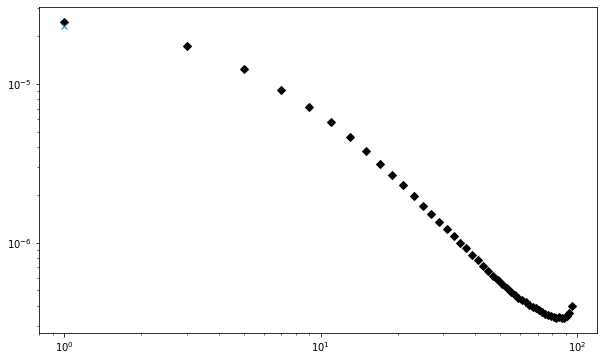

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(bad_cen_rads, averages, 'D',color="black")
plt.plot(cen_rads, rt_emissivity, 'x', label="Normal RateMap")

plt.xscale("log")
plt.yscale("log")
plt.show()

# Big boy XXL Cluster

In [24]:
# bigboy = GalaxyCluster(37.926, -4.881, redshift=0.186, name="XLSSC91", r500=Quantity(1150, "kpc"), 
#                        custom_region_radius=Quantity(1150, "kpc"), use_peak=True)
bigboy = GalaxyCluster(355.431, -55.965, redshift=0.188, name="XLSSC541", r500=Quantity(810, "kpc"), 
                       custom_region_radius=Quantity(810, "kpc"), use_peak=True, clean_obs=False)

/Users/dt237/code/PycharmProjects/XGA/xga/products/phot.py:69: UserWarning: You are loading an ratemap with elements that are < 0, they will be set to 0.
  "they will be set to 0.".format(self._prod_type))


In [25]:
bigboy.info()


-----------------------------------------------------
Source Name - XLSSC541
User Coordinates - (355.431, -55.965) degrees
X-ray Centroid - (355.4348173692319, -55.96408199624219) degrees
nH - 0.0113 1e+22 / cm2
Redshift - 0.188
XMM ObsIDs - 3
PN Observations - 3
MOS1 Observations - 3
MOS2 Observations - 3
On-Axis - 1
With regions - 3
Total regions - 100
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 18
Combined Ratemaps associated - 2
Spectra associated - 0
Custom Region Radius - 810.0 kpc
Custom Region SNR - 1.29
R500 - 810.0 kpc
R500 SNR - 1.29
-----------------------------------------------------



0.0003554926851059078 ct s
0.0003554926851059078 ct s
0.00020839373204682767 ct s


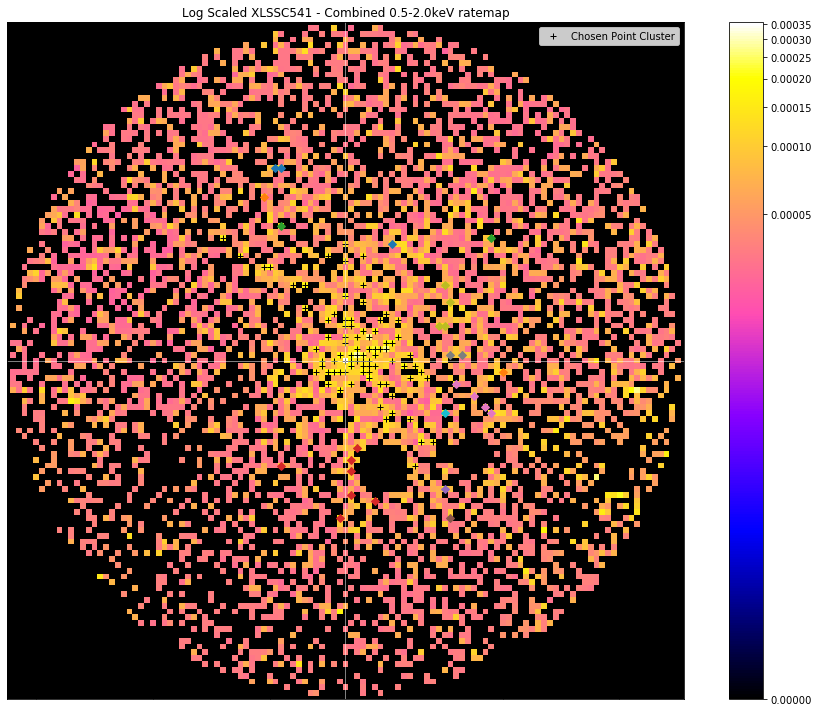

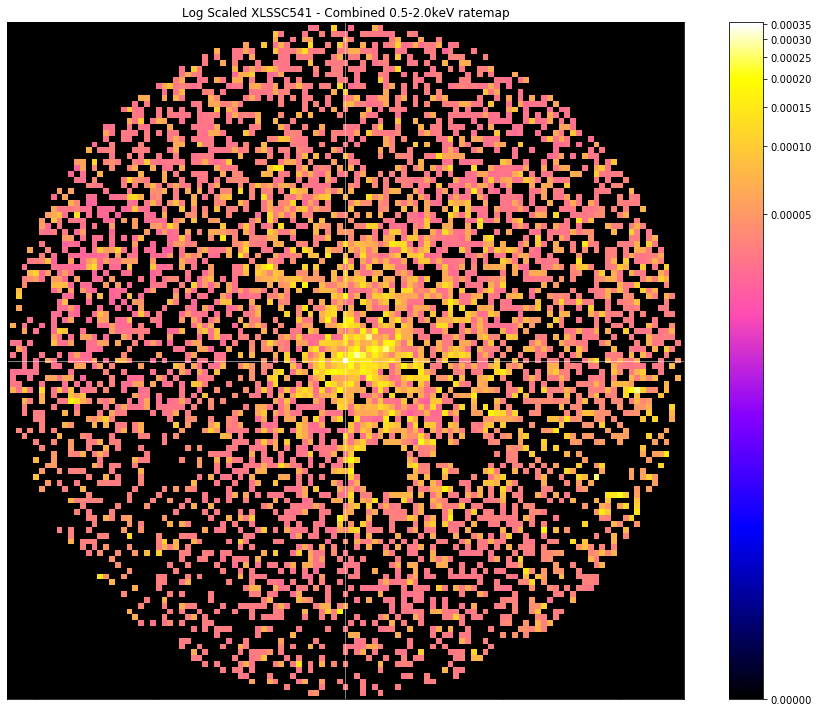

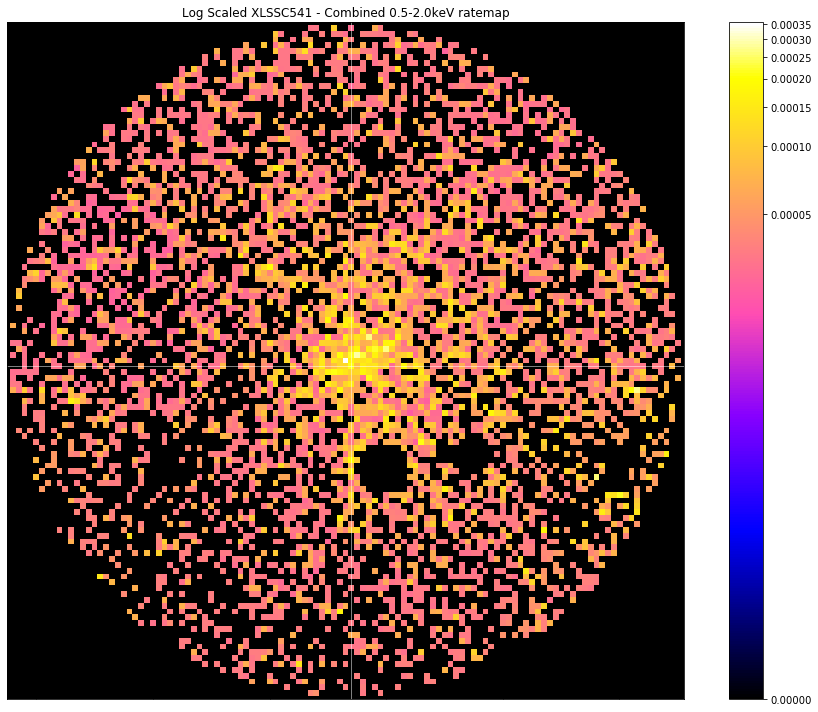

In [26]:
xxl_rt = [r[-1] for r in bigboy.get_products("combined_ratemap", just_obj=False) if "bound_0.5-2.0" in r][0]
xxl_psf_rt = [r[-1] for r in bigboy.get_products("combined_ratemap", just_obj=False) 
              if "bound_0.5-2.0_ELLBETA_4_rl15" in r][0]
r500_mask = bigboy.get_mask("r500")[0]

rt_peak_pack = bigboy.find_peak(xxl_rt, peak_unit=pix)
print(xxl_rt.get_rate(rt_peak_pack[0]))
print(xxl_rt.get_rate(bigboy.peak))
print(xxl_rt.get_rate(bigboy.ra_dec))

xxl_rt.view(bigboy.peak, r500_mask, *bigboy.point_clusters, figsize=(13, 10), zoom_in=True)
xxl_rt.view(bigboy.peak, r500_mask, figsize=(13, 10), zoom_in=True)
xxl_rt.view(bigboy.ra_dec, r500_mask, figsize=(13, 10), zoom_in=True)

### Gonna have a try at smoothing and see where that gets me

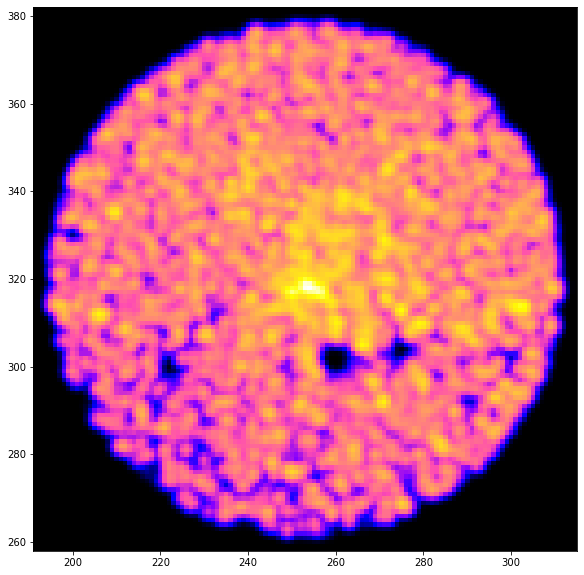

In [27]:
smoother = Gaussian2DKernel(1)
smoothed = convolve(xxl_psf_rt.data * r500_mask, smoother)
plt.figure(figsize=(10, 10))
smooth_norm = ImageNormalize(smoothed, interval=MinMaxInterval(), stretch=LogStretch())
plt.imshow(smoothed, norm=smooth_norm, origin="lower", cmap="gnuplot2")
xlims, ylims = data_limits(smoothed)
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

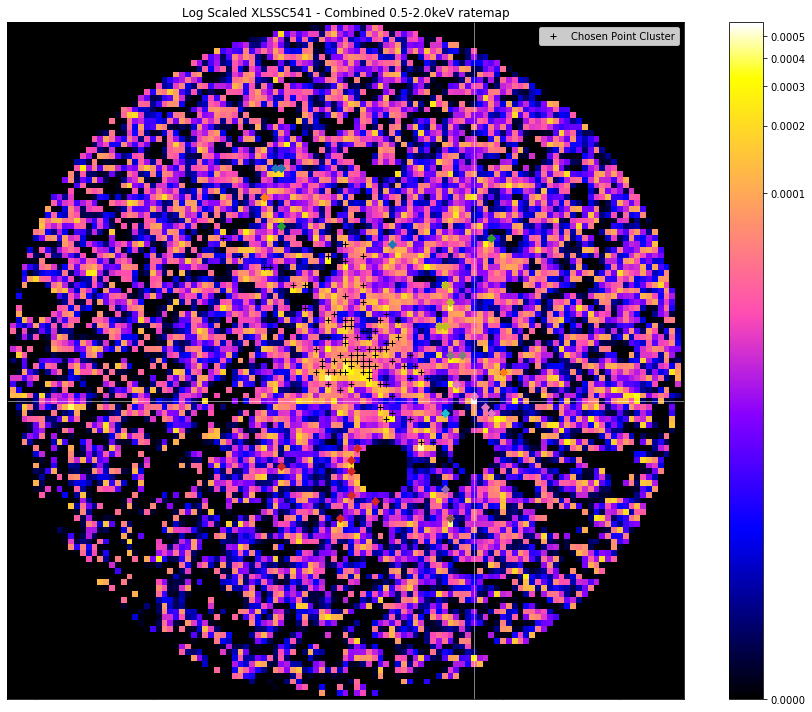

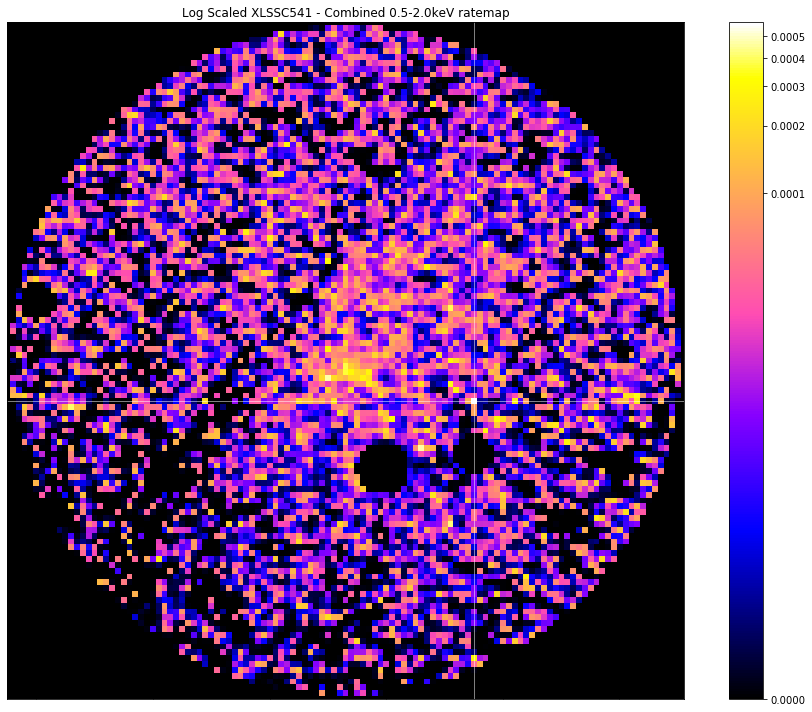

In [28]:
psf_rt_peak_pack = bigboy.find_peak(xxl_psf_rt)
psf_rt_peak = psf_rt_peak_pack[0]
xxl_psf_rt.view(psf_rt_peak, r500_mask, *bigboy.point_clusters, figsize=(13, 10), zoom_in=True)
xxl_psf_rt.view(psf_rt_peak, r500_mask, figsize=(13, 10), zoom_in=True)

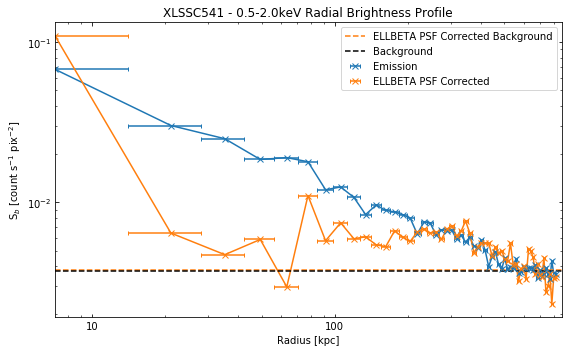

In [29]:
bigboy.view_brightness_profile("r500", 'radial', same_peak=False)